***

# NGCF
 - 사용자와 아이템의 이분 그래프 구조를 기반으로 상호작용에 대한 가중치를 추정하여 사용자와 아이템의 임베딩을 구함으로써 평점을 예측하는 기법
 
### - Reference: [Neural Graph Collaborative Filtering](https://arxiv.org/pdf/1905.08108v2.pdf)

### - Prediction:
평점 $y_{ui}$에 대해서 아래와 같이 예측
<center> $\hat{y}(u, i) = e^{*T}_u e^*_i$ </center>


|expression|mean|
|:---:|:---:|
|$e_u^*$|$$(e^{(0)T}_u, e^{(1)T}_u, ..., e^{(L)T}_u)^T$$, 초기 임베딩(원핫)과 L개의 그래프 레이어를 통과한 각각의 벡터의 concatenate|

### - Optimization:
사용자 u의 평점이 관측된 아이템 i와 관측되지 않은 아이템 j에 대하여 아래와 같은 목적함수를 최소화하는 minima를 찾음으로써 파라미터를 추정함
<center>$\sum_{(u,i,j)\in O} -ln\sigma(\hat{y_{ui}}-\hat{y_{uj}}) + \lambda ||\Theta||^2_2$</center>

|expression|mean|
|:---:|:---:|
|$O$|사용자 $u$와 평점이 관측된 아이템 $i$, 관측되지 않은 아이템 $j$의 집합<br />관측된 하나의$i$에 대하여 k개의 $j$를 임의추출하여 $(u, i, j)$을 만듬, $i$는 복원추출될 수 있음|
|$\lambda||\Theta||^2_2$|규제항 파라미터를 대각원소로 같는 공분산 |

    
### - Evaluation:
|split|measure|
|:---:|:---:|
|holdout|NDCG|

***

## 0) Import library

In [30]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

from Generator.PairwiseGenerator import PairwiseGenerator
from Models.NGCF import NGCF

import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

***

## 1) Data processing

### load data

In [31]:
ratings = pd.read_csv('../data/movie_lens/ratings.csv',
                      names=['user_id', 'item_id', 'rating', '_'],
                      skiprows=1).drop(columns=['_'])
ratings

,user_id,item_id,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


### remain item if count>10 per users

In [32]:
while True:
    if (min(ratings.groupby('item_id').count()['user_id']) >= 10) and\
       (min(ratings.groupby('user_id').count()['item_id']) >= 1):
        break

    lower_item_per_user = ratings.groupby('user_id').count()['item_id']<1
    remove_user_ids = lower_item_per_user[lower_item_per_user==True].index
    ratings = ratings[ratings.user_id.isin(remove_user_ids)==False]

    lower_user_per_item = ratings.groupby('item_id').count()['user_id']<10
    remove_item_ids = lower_user_per_item[lower_user_per_item==True].index
    ratings = ratings[ratings.item_id.isin(remove_item_ids)==False]
    
ratings

,user_id,item_id,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100818,610,159093,3.0
100829,610,164179,5.0
100830,610,166528,4.0
100833,610,168250,5.0


### convert id to index

In [33]:
user_ids = ratings['user_id'].unique().tolist()
item_ids = ratings['item_id'].unique().tolist()

num_user = len(user_ids)
num_item = len(item_ids)

id_to_index_user = {user_ids[i] :i for i in range(num_user)}
id_to_index_item = {item_ids[i] :i for i in range(num_item)}

ratings['user_id'] = ratings['user_id'].apply(lambda x: id_to_index_user[x])
ratings['item_id'] = ratings['item_id'].apply(lambda x: id_to_index_item[x])

ratings

,user_id,item_id,rating
0,0,0,4.0
1,0,1,4.0
2,0,2,4.0
3,0,3,5.0
4,0,4,5.0
...,...,...,...
100818,609,1082,3.0
100829,609,1083,5.0
100830,609,854,4.0
100833,609,1917,5.0


### convert explicit feedback to implicit feedback

In [34]:
ratings['rating'] = 1
ratings

,user_id,item_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
100818,609,1082,1
100829,609,1083,1
100830,609,854,1
100833,609,1917,1


### split data

In [35]:
val_ratio = 0.1
test_ratio = 0.2
seed = 1234

train, others = train_test_split(ratings,
                                 test_size=val_ratio+test_ratio,
                                 shuffle=True,
                                 random_state=seed)

validation, test = train_test_split(others,
                                    test_size=test_ratio/(val_ratio+test_ratio),
                                    shuffle=True,
                                    random_state=seed)

print(f"# of observation(train/val/test): {len(train)}, {len(validation)}, {len(test)}")

# of observation(train/val/test): 56781, 8111, 16224


### set config & get dataset from generator

In [36]:
class DatasetConfig:
    num_negative = 2
    between_observed = False
    batch = 512
    
dataset_config = DatasetConfig()

In [37]:
dataset = PairwiseGenerator(train_data=train,
                            n_user=num_user,
                            n_item=num_item,
                            config=dataset_config)

### see example data for a batch

In [38]:
train_loader = DataLoader(dataset, batch_size=2)
data1, data2, data3 = next(iter(train_loader))

(1) [user id X batch_size]

In [39]:
data1

tensor([56, 56])

(2) [item id_pos X batch_size]

In [40]:
data2

tensor([1660, 1660])

(3) [item id_neg X batch_size]

In [41]:
data3

tensor([1990,  143])

note. item_id_pos : positive item, item_id_neg : negative item

***

## 2) Modeling

### set config & get model

In [42]:
class OptimizerConfig:
    method = 'Adam'
    regulation = 1e-5
    learning_rate = 0.01
    learning_decay = 0.95

class ModelConfig:
    epochs = 10
    print_step = 1

class NGCFConfig:
    evaluation = 'NDCG'
    k = 20
    dim_embedding = 16
    num_layer = 3
    dropout_msg = 0.1
    dropout_node = 0.0

optimizer_config = OptimizerConfig()
ngcf_config = NGCFConfig()
model_config = ModelConfig()

In [43]:
inputs = {"n_user":num_user,
          "n_item":num_item}

model = NGCF(inputs, model_config, optimizer_config, ngcf_config)

[BaseModel] method = Adam
[BaseModel] regulation = 1e-05
[BaseModel] learning_rate = 0.01
[BaseModel] learning_rate_decay = 0.95


### fit model & see loss and performance

In [44]:
train_loader = DataLoader(dataset, batch_size=dataset_config.batch)
model.fit(train_loader=train_loader, val_data=validation)


[NGCF]============================================== Train ===============================================
[NGCF]              (train: BPRloss)    (validation: NDCG)  
          (epoch 1) 233.5246            0.0220              
          (epoch 2) 190.1070            0.0295              
          (epoch 3) 166.4130            0.0314              
          (epoch 4) 146.2037            0.0337              
          (epoch 5) 132.9830            0.0354              
          (epoch 6) 121.2350            0.0338              
          (epoch 7) 113.4099            0.0351              
          (epoch 8) 106.6019            0.0354              
          (epoch 9) 102.5700            0.0346              
         (epoch 10) 96.6409             0.0347              


***

## 3) Evaluation

### evaluate testset

In [45]:
model.test(train_loader=train_loader, test_data=test)


[NGCF]============================================= Evaluate =============================================
[NGCF] (test: NDCG) = 0.0447


### see plot for loss and performance

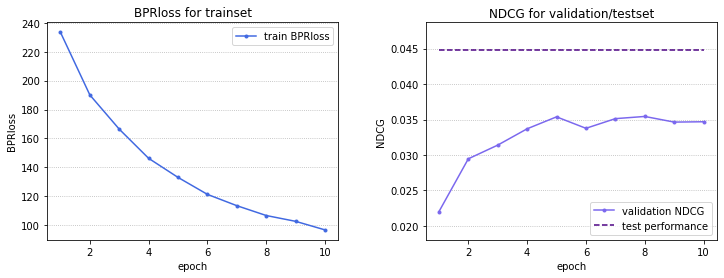

In [46]:
figure = model.draw_plot()
plt.show()